# Face Recognition using Transfer Learning

Face recognition involves the task where the model should be able to see an input image and predict whether it belongs to one of the persons whose image is stored in the database.

We shall use **Transfer Learning** for this task where a pre trained model will be used in order to encode the database images and input images. This pretrained model is is using multiple inception blocks which are trained on the the huge original data of facenet.

The basic idea is that images are encoded using model into vectors. If any two images are encoded then the vector Norm of the difference of these two images is small if two images belong to same person. This Norm is quite larger for two images belonging to different persons.    

Firstly, we shall get the essential libraries for the task

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
import PIL

%matplotlib inline
%load_ext autoreload
%autoreload 2

Now the following function takes the pretrained keras-facenet model and its weights on different layers. This model includes a number of inception blocks that together work and give out an encoding for an input image.
An example of a chain of inception blocks is shown in the following image. [Courtesy of CNN Course DeepLearning.ai]
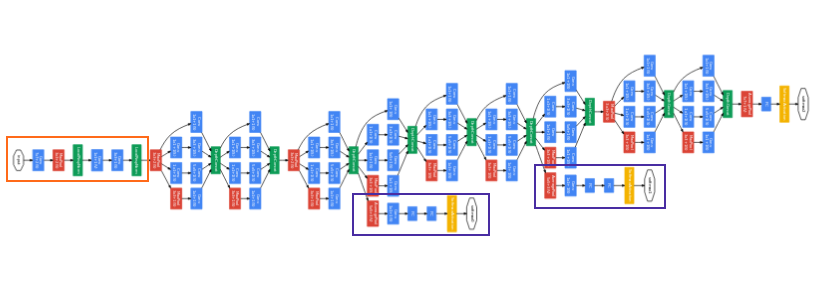

The network architecture follows the Inception model from [Szegedy et al.](https://arxiv.org/abs/1409.4842)

In [ ]:
from tensorflow.keras.models import model_from_json

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('model.h5')

A look at the inputs and outputs of the model.

In [ ]:
print(model.inputs)
print(model.outputs)

[<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]


This model takes an image of size 160 X 160 in RGB and after going through many Inception blocks, we get an encoding representing the image in 128 nodes or of the shape 128.
Here (None, 128) shows the number of images input at a time. For this task that is going to be 1 and hence shape was called 128.

This function will take an image and model as input and provide the encoding of that image as an output. Every image is first converted to stadard size of data for this model, which was 160 X 160. Encoding is generated, standardized and returned.

In [ ]:
def img_to_encoding(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
    img = np.around(np.array(img) / 255.0, decimals=12)
    x_train = np.expand_dims(img, axis=0)
    embedding = model.predict_on_batch(x_train)
    return embedding / np.linalg.norm(embedding, ord=2)

Now Let us make a dictionary that will serve as database where keys are names and values are encodings of a picture of that person.

In [ ]:
database = {}
database["tom"] = img_to_encoding("tom1.jpg", model)
database["matt"] = img_to_encoding("matt1.jpg", model)

These two images are used as refernce encodings for Tom and Matt.

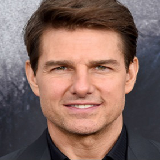

In [ ]:
tom = tf.keras.preprocessing.image.load_img('tom1.jpg', target_size=(160, 160))
tom

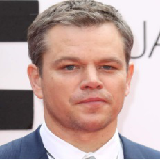

In [ ]:
matt = tf.keras.preprocessing.image.load_img('matt1.jpg', target_size=(160, 160))
matt

Now we have a database to check from. Any new image wil be converted to its encoded vector and then calculate the Norm of difference with the ones in database. If for anyone pair loss is less than threshold, it is a match and message is displayed Welcoming. 

In [ ]:
def Face_Recog(image_path, database, model):
    
    encoding =  img_to_encoding(image_path, model)
    min_dist = 100
    
    #this loop compares encoding of input image with all there in database and returns the least loss and 
    #corresponding name
    for (name, db_enc) in database.items():
        dist = np.linalg.norm(encoding-db_enc)
        if dist < min_dist:
            min_dist = dist
            identity = name
    
    #select a hyperparameter that is low enough to avoid invalid recognition and high enough to not miss 
    #a valid positive recognition
    if min_dist > 0.9:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

The output has a message, whether person is found in database or not. Also it renders the distance, meaning smallest Norm value of input with one of the images in database.

Checking the results on images of people in the database

In [ ]:
Face_Recog("tom2.jpg", database, model)

it's tom, the distance is 0.7883155


(0.7883155, 'tom')

In [ ]:
Face_Recog("tom3.jpg", database, model)

it's tom, the distance is 0.7627842


(0.7627842, 'tom')

In [ ]:
Face_Recog("tom4.jpg", database, model)

it's tom, the distance is 0.85459536


(0.85459536, 'tom')

In [ ]:
Face_Recog("matt2.jpg", database, model)

it's matt, the distance is 0.57481307


(0.57481307, 'matt')

In [ ]:
Face_Recog("matt3.jpg", database, model)

it's matt, the distance is 0.6952904


(0.6952904, 'matt')

Checking the results on people not in database

In [ ]:
Face_Recog("john2.jpg", database, model)

Not in the database.


(1.1496717, 'tom')

In [ ]:
Face_Recog("nottom1.jpg", database, model)

Not in the database.


(1.1932464, 'tom')

In [ ]:
Face_Recog("mark1.jpg", database, model)

Not in the database.


(1.0882547, 'matt')